# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *
from fastprogress.fastprogress import format_time, master_bar, progress_bar

[Jump_to notebook introduction in lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3167)

# Data

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
len(data.train_ds), len(data.valid_ds)

(50000, 10000)

In [5]:
len(data.train_dl), len(data.valid_dl)

(98, 10)

# Helpful Functions

In [6]:
def listify(obj):
    """Convert `obj` to list"""
    if obj is None:
        return []
    if isinstance(obj, str):
        return [obj]
    if isinstance(obj, list):
        return obj
    if isinstance(obj, Iterable):
        return list(obj)
    return [obj]

In [7]:
listify('test'), listify(None), listify((1, 2)), listify([1]), listify(2)

(['test'], [], [1, 2], [1], [2])

In [8]:
def camel2snake(name):
    """
    Convert name of callback by inserting underscores between small and capital
    letters. For example, `TestCallback` becomes `test_callback`.
    """
    pattern1 = re.compile("(.)([A-Z][a-z]+)")
    pattern2 = re.compile("([a-z0-9])([A-Z])")
    name = re.sub(pattern1, r"\1_\2", name)
    return re.sub(pattern2, r"\1_\2", name).lower()

In [9]:
camel2snake('TestCallbackAnotherTest')

'test_callback_another_test'

In [10]:
# pattern1 = re.compile("(.)([A-Z][a-z]+)")
pattern2 = re.compile("([a-z0-9])([A-Z])")
name = re.sub(pattern2, r"\1_\2", 'TestCallbackAnotherTest')
re.sub("Callback", "", name)

'Test__Another_Test'

# Callbacks

Basic class handling tweaks of the training loop by changing a [Learner](https://dev.fast.ai/13a_learner#Learner) in various events.

The training loop consists of a minimal set of instructions; looping through the data we:
- compute the output of the model from the input
- calculate a loss between this output and the desired target
- compute the gradients of this loss with respect to all the model parameters
- update the parameters accordingly
- zero all the gradients

Any tweak of this training loop is defined in a [Callback](https://dev.fast.ai/callback.core#Callback) to avoid over-complicating the code of the training loop, and to make it easy to mix and match different techniques (since they'll be defined in different callbacks). A callback can implement actions on the following events:
1. `before_fit`: called before doing anything, ideal for initial setup
1. `before_epoch`: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch
1. `before_train`: called at the beginning of the training part of an epoch
1. `before_batch`: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance)
1. `after_pred`: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss
1. `after_loss`: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance)
1. `after_backward`: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance)
1. `after_step`: called after the step and before the gradients are zeroed
1. `after_cancel_batch`: reached immediately after a `CancelBatchException` before proceeding to `after_batch`
1. `after_batch`: called at the end of a batch, for any clean-up before the next one
1. `after_cancel_train`: reached immediately after a `CancelTrainException` before proceeding to `after_train`
1. `after_train`: called at the end of the training phase of an epoch
1. `before_validate`: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation
1. `after_cancel_validate`: reached immediately after a `CancelValidateException` before proceeding to `after_validate`
1. `after_validate`: called at the end of the validation part of an epoch
1. `after_cancel_epoch`: reached immediately after a `CancelEpochException` before proceeding to `after_epoch`
1. `after_epoch`: called at the end of an epoch, for any clean-up before the next one
1. `after_cancel_fit`: reached immediately after a `CancelFitException` before proceeding to `after_fit`
1. `after_fit`: called at the end of training, for final clean-up

In [11]:
# export
class Callback:
    # Determines the order of the when each callback is run; useful when
    # are dealing with transformation
    _order = 0
    def set_learner(self, learner): 
        self.learner = learner

    # This is used if we try to access a callback attribute
    # but most likely the attribute is from runner.
    def __getattr__(self, k):
        return getattr(self.learner, k)

    @property
    def name(self):
        '''
        Returns the name of the callback after removing the word `callback` 
        and then convert it to snake (split words by underscores).
        '''
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    # We have this method here so that the user has more flexibility
    # about what to do when each callback is called. we can just change
    # the behavior of the __call__ method
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f():
            return True
        return False

    @staticmethod
    def camel2snake(name):
        """
        Convert name of callback by inserting underscores between small and capital
        letters. For example, `TestCallback` becomes `test_callback`.
        """
        pattern1 = re.compile("(.)([A-Z][a-z]+)")
        pattern2 = re.compile("([a-z0-9])([A-Z])")
        name = re.sub(pattern1, r"\1_\2", name)
        return re.sub(pattern2, r"\1_\2", name).lower()

In [12]:
# export
class CancelFitException(Exception):
    """Stop training and exit"""

    pass


class CancelEpochException(Exception):
    """Stop current epoch and move to next epoch."""

    pass


class CancelTrainException(Exception):
    """Stop training current batch and move to validation."""

    pass


class CancelValidException(Exception):
    """Stop validation phase and move to next epoch"""

    pass


class CancelBatchException(Exception):
    """Stop current batch and move to next batch."""

    pass

In [13]:
# export
class TrainEvalCallback(Callback):
    """
    Tracks the number of iterations and epoch done and set training and eval
    modes.
    """

    def before_fit(self):
        self.learner.n_iters = 0
        self.learner.pct_train = 0

    def after_batch(self):
        if self.learner.training:
            self.learner.n_iters += 1
            self.learner.pct_train += 1 / (self.iters * self.n_epochs)

    def before_train(self):
        self.model.train()
        self.learner.training = True
        self.learner.pct_train = self.epoch / self.n_epochs

    def before_validate(self):
        self.model.eval()
        self.learner.training = False

# Learner

In [14]:
# export
class Learner:
    ALL_CBS = {
        "before_fit",
        "before_epoch",
        "before_train",
        "before_validate",
        "before_batch",
        "after_pred",
        "after_loss",
        "after_backward",
        "after_step",
        "after_cancel_batch",
        "after_batch",
        "after_cancel_train",
        "after_train",
        "after_cancel_validate",
        "after_validate",
        "after_cancel_epoch",
        "after_epoch",
        "after_cancel_fit",
        "after_fit",
    }


    def __init__(self, model, data, loss_func, opt, cbs=None, cb_funcs=None):
        self.model = model
        self.data = data
        self.loss_func = loss_func
        self.opt = opt
        self.training = False
        self.logger = print # We can customize it and use it in something like progress bar or log to a file

        # Callbacks
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(listify(cbs))
        self.add_cbs([cb_func() for cb_func in listify(cb_funcs)])

    def add_cbs(self, cbs):
        for cb in cbs:
            self.add_cb(cb)

    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in cbs:
            self.cbs.remove(cb)

    def _one_batch(self, i, xb, yb):
        self.iter = i
        self.xb, self.yb = xb, yb
        try:
            self("before_batch")
            self.pred = self.model(self.xb)
            self("after_pred")
            self.loss = self.loss_func(self.pred, self.yb)
            self("after_loss")
            if not self.training:
                return
            self.loss.backward()
            self("after_backward")
            self.opt.step()
            self("after_step")
            self.opt.zero_grad()
        except CancelBatchException:
            self("after_cancel_batch")
        finally:
            self("after_batch")

    def _all_batches(self):
        self.iters = len(self.dl)
        for i, (xb, yb) in enumerate(self.dl):
            self._one_batch(i, xb, yb)

    def fit(self, epochs):
        self.n_epochs = epochs
        try:
            self("before_fit")
            for epoch in range(self.n_epochs):
                try:
                    self.epoch = epoch
                    self.dl = self.data.train_dl
                    self("before_epoch")

                    try:
                        self("before_train")
                        self._all_batches()
                    except CancelTrainException:
                        self("after_cancel_train")
                    finally:
                        self("after_train")

                    try:
                        self.dl = self.data.valid_dl
                        self("before_validate")
                        with torch.no_grad():
                            self._all_batches()
                    except CancelValidException:
                        self("after_cancel_validate")
                    finally:
                        self("after_validate")
                except CancelEpochException:
                    self("after_cancel_epoch")
                finally:
                    self("after_epoch")
        except CancelFitException:
            self("after_cancel_fit")
        finally:
            self("after_fit")
            self.learn = None

    def __call__(self, cb_name):
        assert cb_name in Learner.ALL_CBS, f"{cb_name} is not a valid callback name"
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) and res
        return res

In [15]:
# # export
# class Runner:
#     def __init__(self, cbs=None, cb_funcs=None):
#         self.cbs = listify(cbs)
#         for cb_func in listify(cb_funcs):
#             cb = cb_func()
#             setattr(self, cb.name, cb)
#             self.cbs.append(cb)
#         self.cbs = [TrainEvalCallback()] + self.cbs

#     @property
#     def model(self):
#         return self.learn.model

#     @property
#     def opt(self):
#         return self.learn.opt

#     @property
#     def loss_func(self):
#         return self.learn.loss_func

#     @property
#     def data(self):
#         return self.learn.data

#     def _one_batch(self, xb, yb):
#         self.xb, self.yb = xb, yb
#         try:
#             self('begin_batch')
#             self.pred = self.model(self.xb)
#             self('after_pred')
#             self.loss = self.loss_func(self.pred, self.yb)
#             self('after_loss')
#             if not self.training:
#                 return
#             self.loss.backward()
#             self('after_backward')
#             self.opt.step()
#             self('after_step')
#             self.opt.zero_grad()
#         except CancelBatchException:
#             self('after_cancel_batch')
#         finally:
#             self('after_batch')

#     def _all_batches(self, dl):
#         self.iters = len(dl)
#         for xb, yb in dl:
#             self._one_batch(xb, yb)
        
#     def fit(self, epochs, learn):
#         self.n_epochs = epochs
#         self.learn = learn

#         try:
#             for cb in self.cbs:
#                 cb.set_runner(self)

#             self('begin_fit')
#             for epoch in range(self.n_epochs):
#                 try:
#                     self('begin_epoch')
#                     self.epoch = epoch
                
#                     try:
#                         self('begin_train') 
#                         self._all_batches(self.data.train_dl)
#                     except CancelTrainException:
#                         self('after_cancel_train')
#                     finally:
#                         self('after_train')

#                     try:
#                         self('begin_validate')
#                         with torch.no_grad():
#                                 self._all_batches(self.data.valid_dl)
#                     except CancelValidException:
#                         self('after_cancel_validate')
#                     finally:
#                         self('after_validate')
#                 except CancelEpochException:
#                     self('after_cancel_epoch')
#                 finally:
#                     self('after_epoch')
#         except CancelFitException:
#             self('after_cancel_fit')
#         finally:
#             self('after_fit')
#             self.learn = None

#     def __call__(self, cb_name):
#         res = False
#         for cb in sorted(self.cbs, key=lambda x: x._order):
#             res = cb(cb_name) or res
#         return res

In [16]:
model, opt = get_model(data)

In [17]:
loss_func = F.cross_entropy

In [18]:
class TestCallback(Callback):
    _order = 1

    def after_step(self):
        self.logger(self.n_iters, self.pct_train)
        if self.n_iters >= 10:
            raise CancelFitException()

In [19]:
learner = Learner(model, data, loss_func, opt, cb_funcs=TestCallback)

In [20]:
learner.fit(3)

0 0.0
1 0.003401360544217687
2 0.006802721088435374
3 0.01020408163265306
4 0.013605442176870748
5 0.017006802721088433
6 0.02040816326530612
7 0.023809523809523808
8 0.027210884353741496
9 0.030612244897959183
10 0.03401360544217687


# Useful callbacks

## Stats

In [21]:
# export
class AvgStats:
    def __init__(self, metrics, training=True):
        self.metrics = listify(metrics)
        self.training = training

    def reset(self):
        self.tot_loss = 0
        self.count = 0
        self.tot_metrics = [0.] * len(self.metrics)

    @property
    def all_stats(self):
        '''Returns a list of both loss and metrics.'''
        return [self.tot_loss.item()] + self.tot_metrics

    @property
    def avg_stats(self):
        '''Returns the average of loss/metrics.'''
        return [o / self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: 
            return ''
        return f"{'train' if self.training else 'valid'}: {self.avg_stats}"

    def accumulate(self, learner):
        '''Evaluate metrics and accumulate them to at the epoch level.'''
        bs = len(learner.xb)
        self.count += bs
        self.tot_loss += learner.loss * bs
        for i, metric in enumerate(self.metrics):
            self.tot_metrics[i] += metric(learner.pred, learner.yb) * bs

In [22]:
# export
class AvgStatsCallback(Callback):
    _order = -10
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def before_epoch(self):
        '''Reset metrics/loss.'''
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        '''Evaluate metrics and accumulate them.'''
        stats = self.train_stats if self.training else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.learner)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [23]:
model, opt = get_model(data)

In [24]:
loss_func = F.cross_entropy

In [25]:
learner = Learner(model, data, loss_func, opt, cbs=AvgStatsCallback([accuracy]))

In [26]:
learner.fit(3)

train: [0.656556328125, tensor(0.8068)]
valid: [0.3059111572265625, tensor(0.9146)]
train: [0.29674427734375, tensor(0.9136)]
valid: [0.2408109130859375, tensor(0.9321)]
train: [0.23895392578125, tensor(0.9308)]
valid: [0.20018004150390625, tensor(0.9443)]


## Recorder

In [27]:
# export
class Recorder(Callback):
    _order = 50
    def before_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.training:
            return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_lr(self, pgid=-1):
        plt.plot(self.lrs[pgid])

    def plot_loss(self, skip_last=0):
        n = len(self.losses) - skip_last
        plt.plot(self.losses[:n])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [28]:
model, opt = get_model(data)

In [29]:
loss_func = F.cross_entropy

In [30]:
learner = Learner(model, data, loss_func, opt, cbs=AvgStatsCallback([accuracy]), cb_funcs=Recorder)

In [31]:
learner.fit(3)

train: [0.674924609375, tensor(0.7978)]
valid: [0.3087734130859375, tensor(0.9110)]
train: [0.3115500390625, tensor(0.9079)]
valid: [0.2528210205078125, tensor(0.9277)]
train: [0.24996732421875, tensor(0.9278)]
valid: [0.221538720703125, tensor(0.9376)]


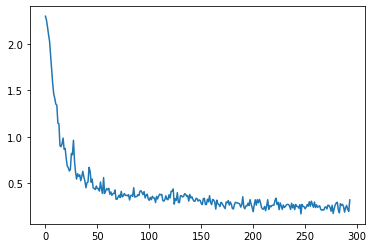

In [32]:
learner.recorder.plot_loss()

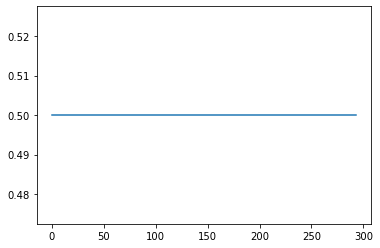

In [33]:
learner.recorder.plot_lr()

## Parameter Scheduler

In [34]:
# export
class ParamScheduler(Callback):
    _order = 60

    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs

    def before_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.pct_train)

    def before_batch(self):
        if self.training:
            self.set_param()

In [35]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [36]:
model, opt = get_model(data)

In [37]:
loss_func = F.cross_entropy

In [38]:
learner = Learner(model, data, loss_func, opt, cbs=[AvgStatsCallback([accuracy]), ParamScheduler('lr', sched)], cb_funcs=Recorder)

In [39]:
learner.fit(3)

train: [0.78102890625, tensor(0.7841)]
valid: [0.3549895263671875, tensor(0.8911)]
train: [0.3018090625, tensor(0.9120)]
valid: [0.236168115234375, tensor(0.9332)]
train: [0.23684572265625, tensor(0.9322)]
valid: [0.209265771484375, tensor(0.9412)]


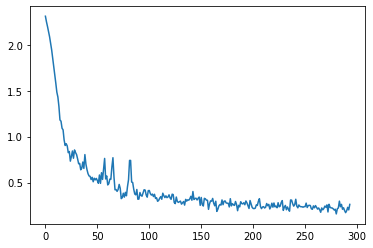

In [40]:
learner.recorder.plot_loss()

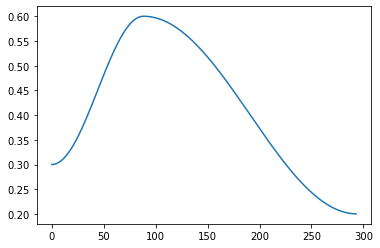

In [41]:
learner.recorder.plot_lr()

## LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [43]:
# export
class LR_Find(Callback):
    _order = 60

    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9

    def before_batch(self):
        if not self.training:
            return
        pos = self.n_iters / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr)**pos
        for pg in self.opt.param_groups:
            pg['lr'] = lr

    def after_step(self):
        if self.n_iters >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelFitException()
        elif self.loss < self.best_loss:
            self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [44]:
model, opt = get_model(data)

In [45]:
loss_func = F.cross_entropy

In [46]:
learner = Learner(model, data, loss_func, opt, cbs=[AvgStatsCallback([accuracy])], cb_funcs=[Recorder, LR_Find])

In [47]:
learner.fit(3)

train: [2.4405178313559674, tensor(0.1947)]



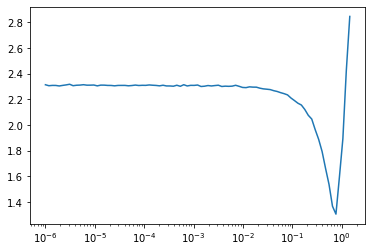

In [48]:
learner.recorder.plot(skip_last=5)

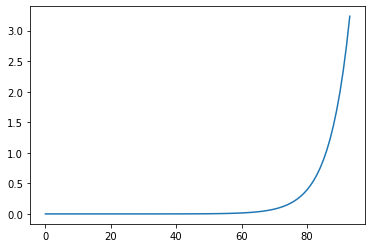

In [49]:
learner.recorder.plot_lr()

## Progress

In [50]:
class ProgressCallback(Callback):
    """Add progress bar as logger for tracking metrics."""

    _order = 60

    def before_fit(self):
        self.mbar = master_bar(range(self.learner.n_epochs))
        self.mbar.on_iter_begin()
        self.learner.logger = partial(self.mbar.write, table=True)

    def after_fit(self):
        self.mbar.on_iter_end()

    def after_batch(self):
        self.pb.update(self.learner.iter)

    def before_epoch(self):
        self.set_pb()

    def before_validate(self):
        self.set_pb()

    def set_pb(self):
        self.pb = progress_bar(self.learner.dl, parent=self.mbar)
        self.mbar.update(self.epoch)

In [51]:
model, opt = get_model(data)

In [52]:
loss_func = F.cross_entropy

In [53]:
learner = Learner(model, data, loss_func, opt, cbs=[AvgStatsCallback([accuracy])], cb_funcs=[Recorder, ProgressCallback])

In [54]:
learner.fit(3)

train: [0.68213546875, tensor(0.7986)]
valid: [0.3151760009765625, tensor(0.9094)]
train: [0.3106803125, tensor(0.9083)]
valid: [0.244204150390625, tensor(0.9318)]
train: [0.2467671875, tensor(0.9285)]
valid: [0.20470655517578126, tensor(0.9424)]


# Export

In [55]:
!python ../src/notebook2script.py 05b_Early_Stopping-Imad.ipynb

Converted 05b_Early_Stopping-Imad.ipynb to exp/nb_05b.py
